# Data Exploration

In [1]:
import sys
import os
import torch
from typing import Tuple, List, Dict
from tqdm import tqdm

# navigates to the main project folder
project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), "../"))
if project_root not in sys.path:
    sys.path.append(project_root)


from src.utils.config_managing import load_yaml_config
from src.utils.plotting import *

dataset_config =load_yaml_config('../config/data_split_config.yaml')
plots_dict = {}

## Lunar Landing Environment

### Environment: <a href="https://gymnasium.farama.org/environments/box2d/lunar_lander/"> Lunar Lander v2  </a>

* Classic rocket trajectory optimization problem
* <b>Discrete actions:</b> engine <b>on</b> or <b>off</b>
    * (Pontryagin’s maximum principle => it is optimal to fire the engine at full throttle or turn it off)
* <b>Two environment versions:</b> discrete or continuous (discrete in our case)
* <b> Fuel is infinite </b> => the agent can learn to fly and then land on its first attempt


### States

*   8-dimensional vectors:
    * [0]: x coordinate
    * [1]: y coordinate
    * [2]: linear velocity in x
    * [3]: linear velocity in y
    * [4]: Lander`s angle
    * [5]: Lander`s angular velocity
    * [6]: Leg 1 contacts the land (boolean)
    * [7]: Leg 2 contacts the land (boolean)

*   <b> Initial State:</b>
    * <b>x, y:</b> starts at the top center of the viewport
    * random initial force applied to its center of mass.

### Action Space

* 0: do nothing
* 1: fire left orientation engine
* 2: fire main engine
* 3: fire right orientation engine

### Rewards
After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each timestep, the reward:
* is increased/decreased the closer/further the lander is to the landing pad.
* is increased/decreased the slower/faster the lander is moving.
* is decreased the more the lander is tilted (angle not horizontal).
* +10 points for each leg that is in contact with the ground.
* -0.03 points each frame a side engine is firing.
* -0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.
An episode is considered a solution if it scores at least 200 points.

## Loading the data

In [2]:
rb_train_df = pd.read_parquet('../data/replay_buffer_episodes/rb_train.parquet')
fp_train_df = pd.read_parquet('../data/final_policy_episodes/fp_train.parquet')

In [3]:
rb_normalization_techniques = {
    'raw': None,
    'Max Abs': torch.jit.load(f'../models/replay_buffer/normalization/max_abs_normalization.pt'),
    'Min Max': torch.jit.load(f'../models/replay_buffer/normalization/min_max_normalization.pt'),
    'Robust': torch.jit.load(f'../models/replay_buffer/normalization/robust_normalization.pt'),
    'Standard (z-score)': torch.jit.load(f'../models/replay_buffer/normalization/standard_normalization.pt'),
}

fp_normalization_techniques = {
    'raw': None,
    'Max Abs': torch.jit.load(f'../models/final_policy/normalization/max_abs_normalization.pt'),
    'Min Max': torch.jit.load(f'../models/final_policy/normalization/min_max_normalization.pt'),
    'Robust': torch.jit.load(f'../models/final_policy/normalization/robust_normalization.pt'),
    'Standard (z-score)': torch.jit.load(f'../models/final_policy/normalization/standard_normalization.pt'),
}

## Descriptive Statistics

In [4]:
display(rb_train_df.describe())
display(fp_train_df.describe())

,X,Y,lv_X,lv_Y,angle,angular_velocity,action,reward,episode
count,801683.000000,801683.000000,801683.000000,801683.000000,801683.000000,801683.000000,801683.000000,801683.000000,801683.000000
mean,0.002973,0.629331,-0.004684,-0.085404,0.003136,0.000475,1.487005,-0.179928,1086.641245
std,0.316991,0.392169,0.258629,0.187380,0.138516,0.097688,0.975303,3.512852,382.185300
min,-0.999973,-0.329198,-2.946522,-2.793877,-3.362800,-6.078868,0.000000,-100.000000,0.000000
25%,-0.176930,0.285636,-0.093550,-0.100920,-0.036053,-0.025748,0.000000,-1.173662,814.000000
50%,0.014015,0.551599,0.012877,-0.042579,0.004139,-0.000468,2.000000,-0.149561,1081.000000
75%,0.187958,0.919961,0.103575,-0.004456,0.039714,0.024428,2.000000,0.895119,1396.000000
max,0.999957,3.649655,3.050443,0.830236,3.603545,6.082865,3.000000,135.202332,1724.000000


,X,Y,lv_X,lv_Y,angle,angular_velocity,action,reward,episode
count,804059.000000,804059.000000,804059.000000,804059.000000,804059.000000,8.040590e+05,804059.000000,804059.000000,804059.000000
mean,-0.032330,0.457843,-0.021234,-0.073373,-0.000511,-4.639259e-04,1.304990,0.097753,625.247095
std,0.280553,0.366351,0.204107,0.088432,0.058326,4.219376e-02,1.003881,3.410921,365.347428
min,-0.999958,-0.220163,-1.136813,-0.621478,-0.695194,-1.057240e+00,0.000000,-100.000000,1.000000
25%,-0.176830,0.164315,-0.076613,-0.103988,-0.032129,-2.040241e-02,0.000000,-1.133095,303.000000
50%,-0.074826,0.363728,0.002986,-0.053789,0.002167,-5.845620e-07,2.000000,-0.083675,624.000000
75%,0.047157,0.690170,0.064678,-0.016084,0.034350,2.008669e-02,2.000000,1.106756,949.000000
max,0.999992,1.528019,0.831265,0.510804,0.423147,7.421849e-01,3.000000,100.000000,1253.000000


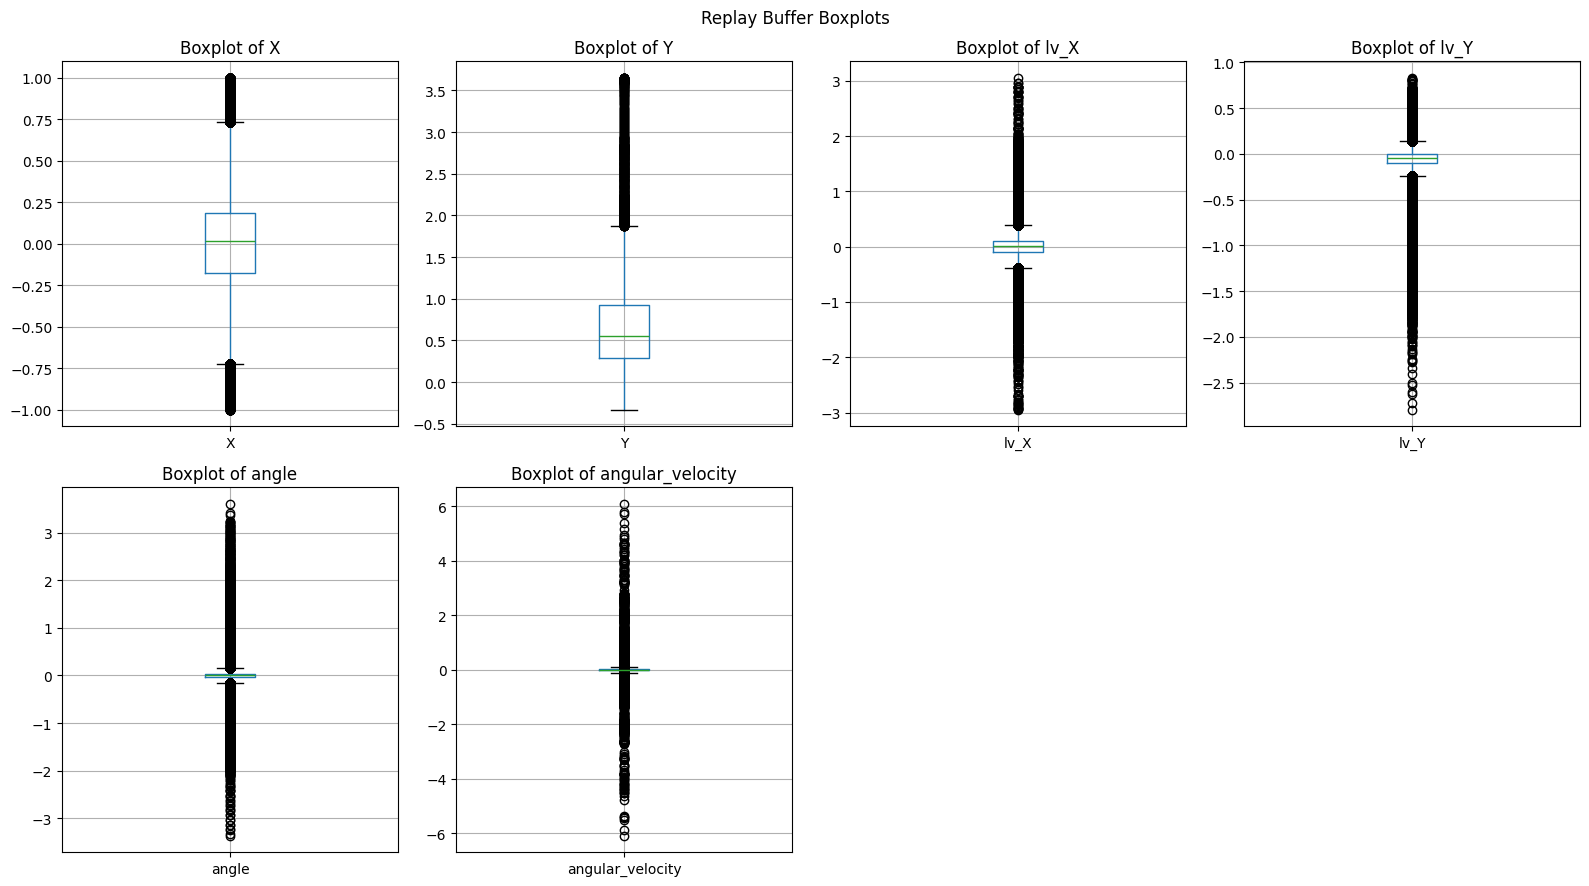

In [5]:
rb_boxplots_fig = plot_boxplots_df(data=rb_train_df[['X', 'Y', 'lv_X', 'lv_Y', 'angle', 'angular_velocity', 'reward']], custom_title='Replay Buffer Boxplots')

plots_dict['../plots/rb_boxplots_fig.png']=rb_boxplots_fig
plt.show(rb_boxplots_fig)

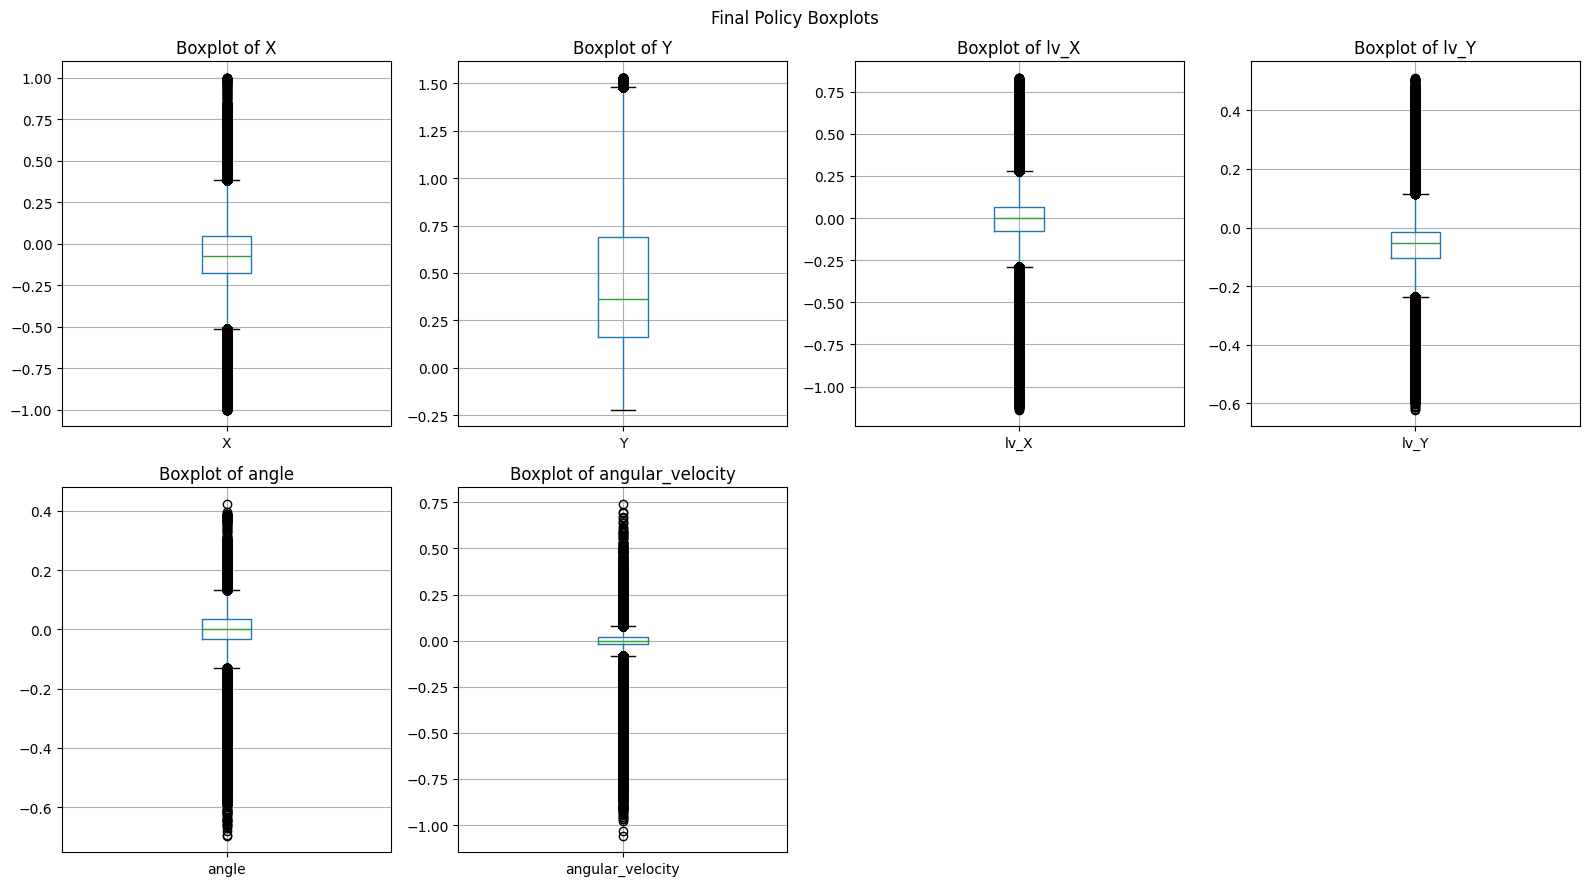

In [6]:
fp_boxplots_fig = plot_boxplots_df(data=fp_train_df[['X', 'Y', 'lv_X', 'lv_Y', 'angle', 'angular_velocity', 'reward']], custom_title='Final Policy Boxplots')

plots_dict['../plots/fp_boxplots_fig.png']=fp_boxplots_fig
plt.show(fp_boxplots_fig)

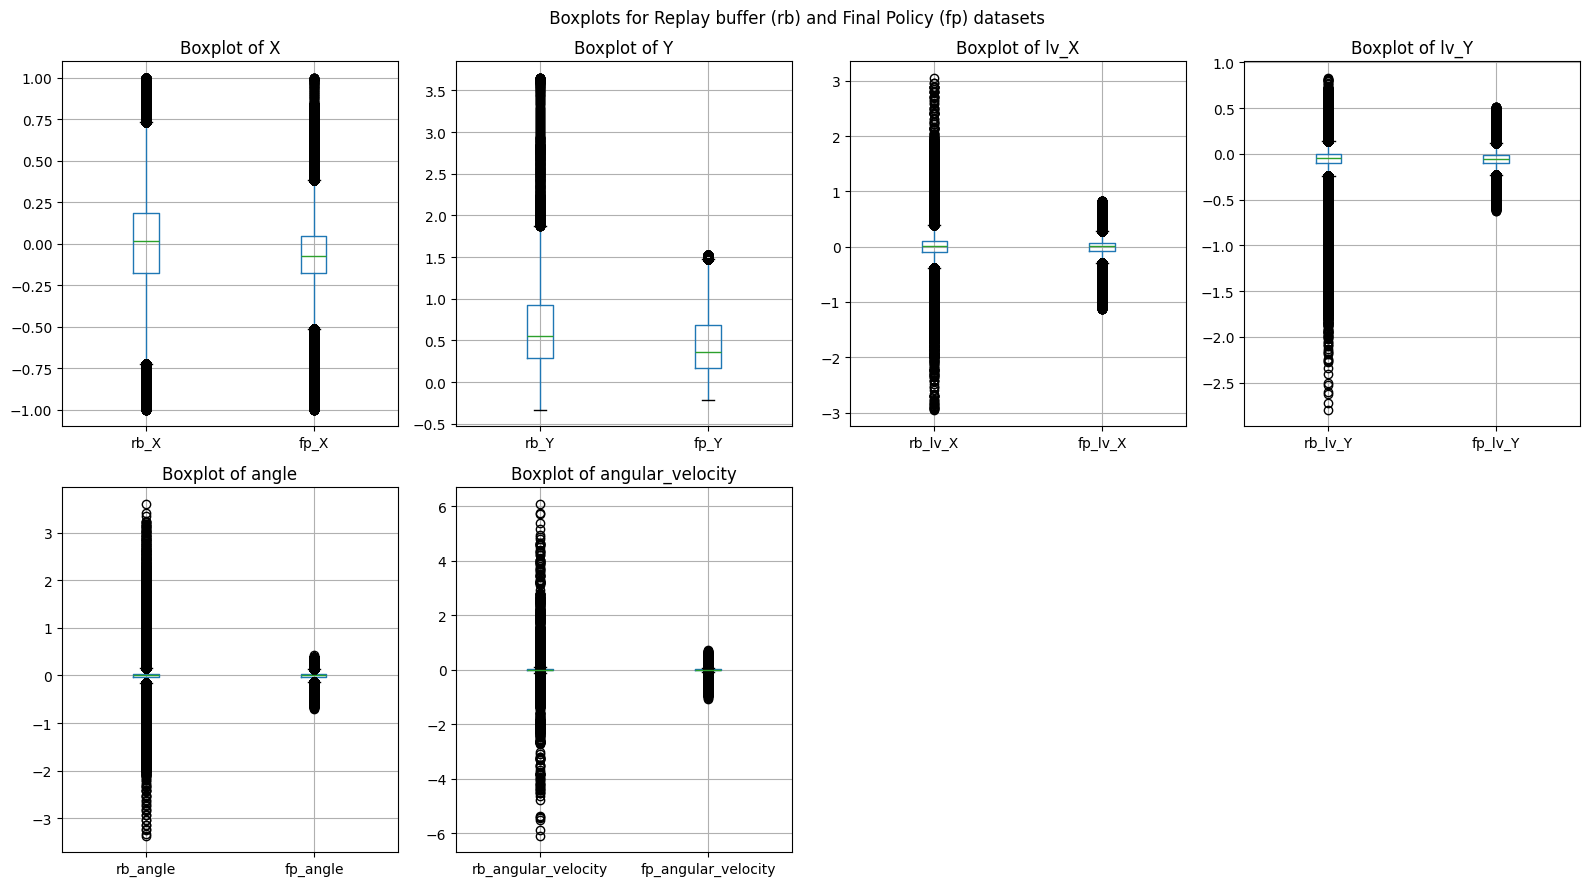

In [7]:
rb_fp_boxplots_combined_fig = plot_boxplots_compare_df(
        df1_name = 'rb',
        df2_name = 'fp',
        df1=rb_train_df[['X', 'Y', 'lv_X', 'lv_Y', 'angle', 'angular_velocity', 'reward']],
        df2=fp_train_df[['X', 'Y', 'lv_X', 'lv_Y', 'angle', 'angular_velocity', 'reward']],
        num_columns=4,
        custom_title=' Boxplots for Replay buffer (rb) and Final Policy (fp) datasets')

plots_dict['../plots/rb_fp_boxplots_combined_fig.png']=rb_fp_boxplots_combined_fig
plt.show(rb_fp_boxplots_combined_fig)

### Univariate Analysis

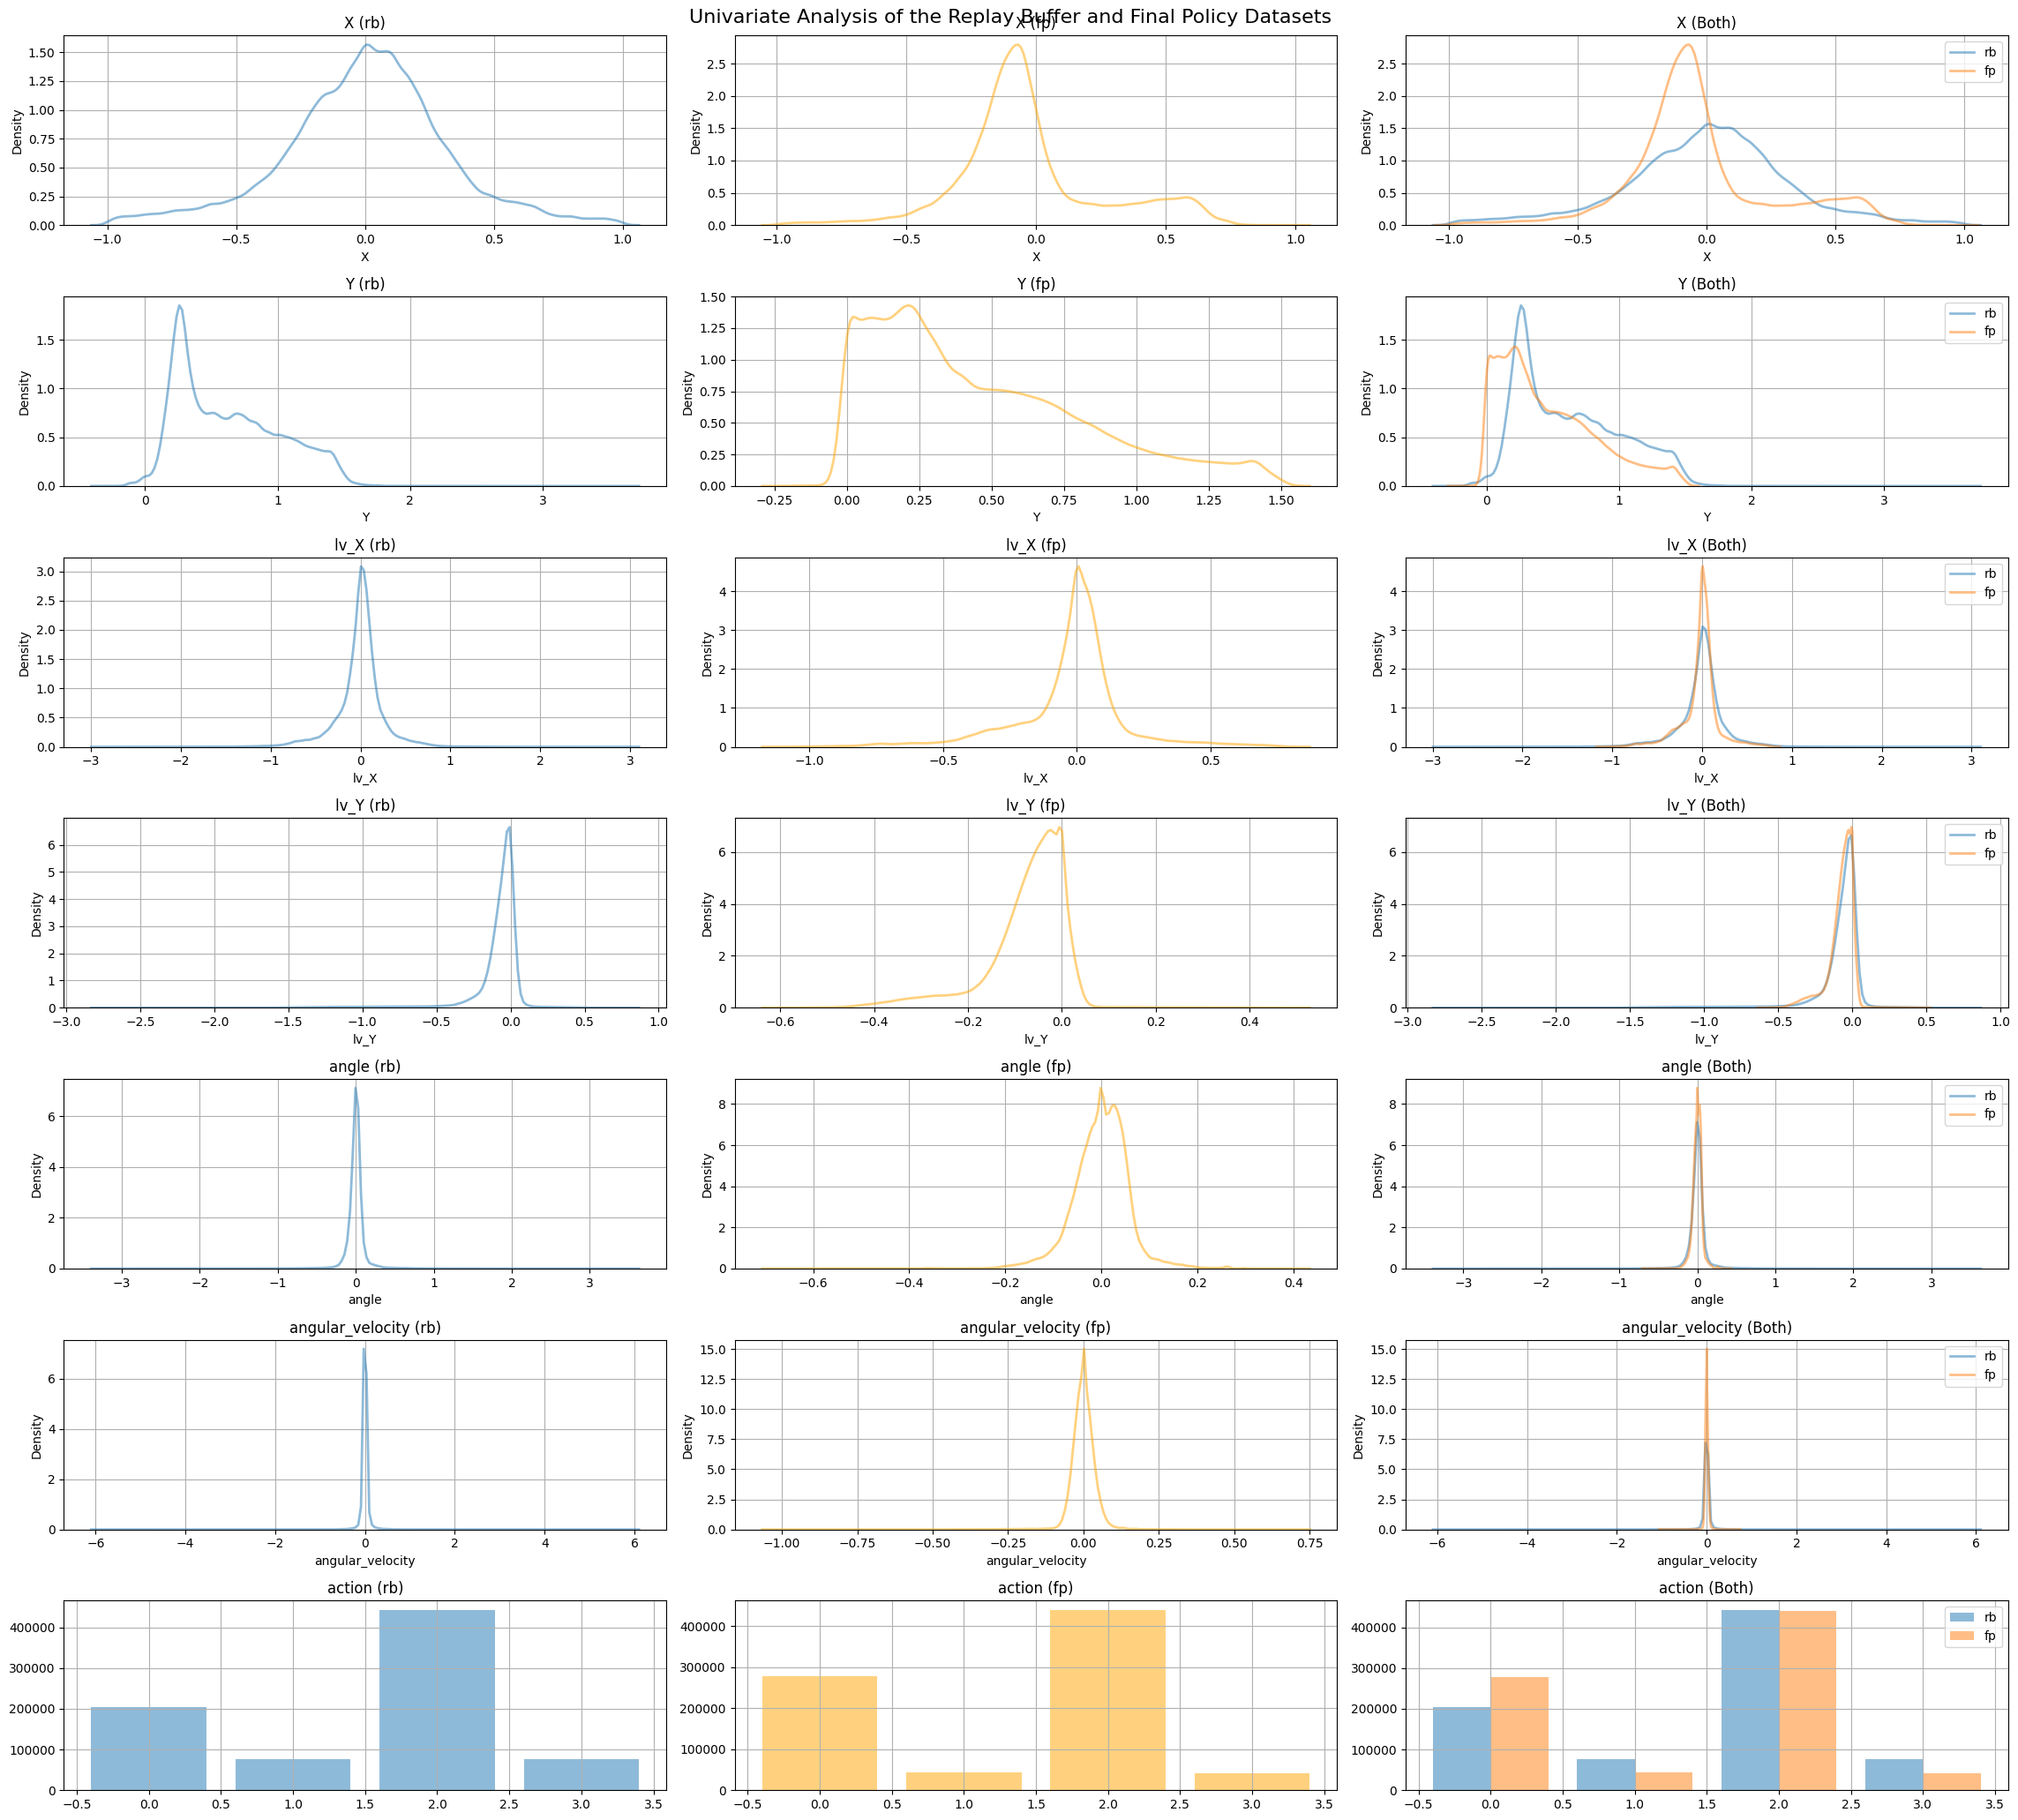

In [8]:
rb_fp_univar_fig = plot_univariate_analysis(
        df1_name = 'rb',
        df2_name = 'fp',
        df1=rb_train_df[['X', 'Y', 'lv_X', 'lv_Y', 'angle', 'angular_velocity', 'action']],
        df2=fp_train_df[['X', 'Y', 'lv_X', 'lv_Y', 'angle', 'angular_velocity', 'action']],
        num_columns=3,
        custom_title='Univariate Analysis of the Replay Buffer and Final Policy Datasets',
        kde_kwargs={'linewidth': 2, 'alpha': 0.5},
        hist_kwargs={'alpha': 0.5, 'bins': [-0.5, 0.5, 1.5, 2.5, 3.5],'align':'mid', 'rwidth': 0.8},
        f_size=(23,21))

plots_dict['../plots/rb_fp_univar_fig.png']=rb_fp_univar_fig
plt.show(rb_fp_univar_fig)

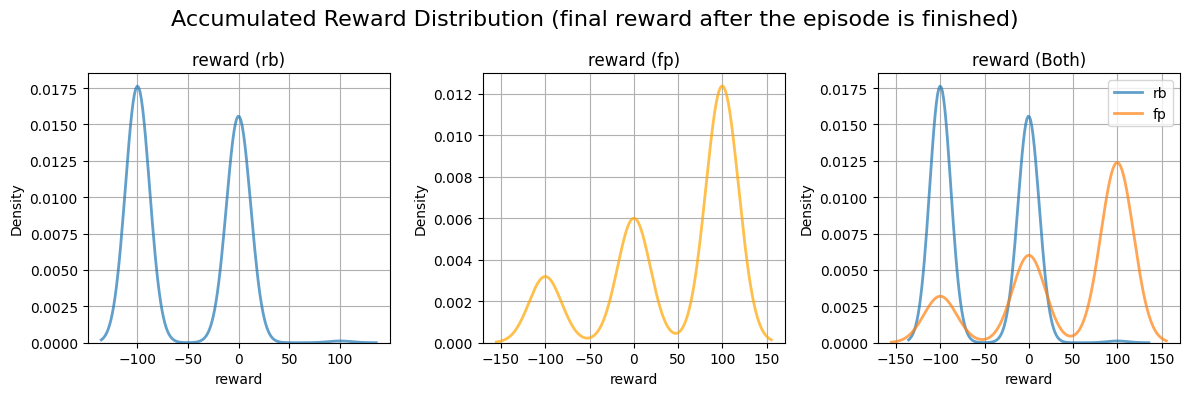

In [9]:
rb_fp_reward_analysis_fig = plot_univariate_analysis(
        df1_name = 'rb',
        df2_name = 'fp',
        df1=rb_train_df[rb_train_df['done'] == True][['reward']],
        df2=fp_train_df[fp_train_df['done'] == True][['reward']],
        num_columns=3,
        custom_title='Accumulated Reward Distribution (final reward after the episode is finished)',
        kde_kwargs={'linewidth': 2, 'alpha': 0.7,},
        f_size=(12,4))

plots_dict['../plots/rb_fp_reward_analysis_fig.png']=rb_fp_reward_analysis_fig
plt.show(rb_fp_reward_analysis_fig)

### Multivariate Analysis

* XY coordinate env exploration

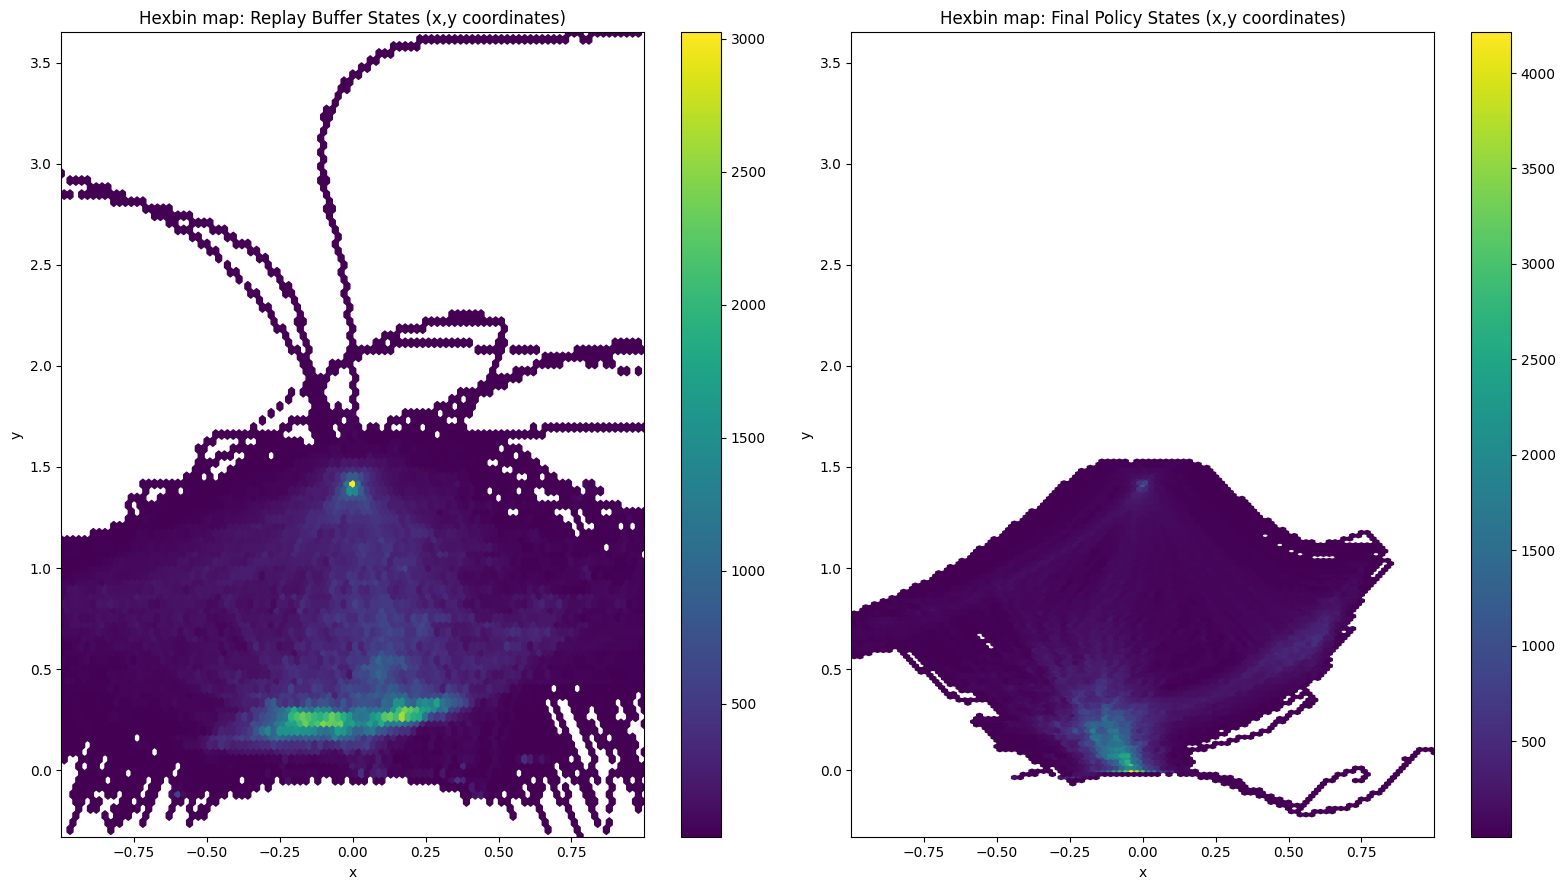

In [10]:
xy_hexbin_fig = plot_hexbin(data_dict={'Replay Buffer States (x,y coordinates)': rb_train_df[['X', 'Y']].to_numpy(),
                                       'Final Policy States (x,y coordinates)': fp_train_df[['X', 'Y']].to_numpy()})

plots_dict['../plots/xy_hexbin_fig.png']=xy_hexbin_fig
plt.show(xy_hexbin_fig)

### Correlation Matrices

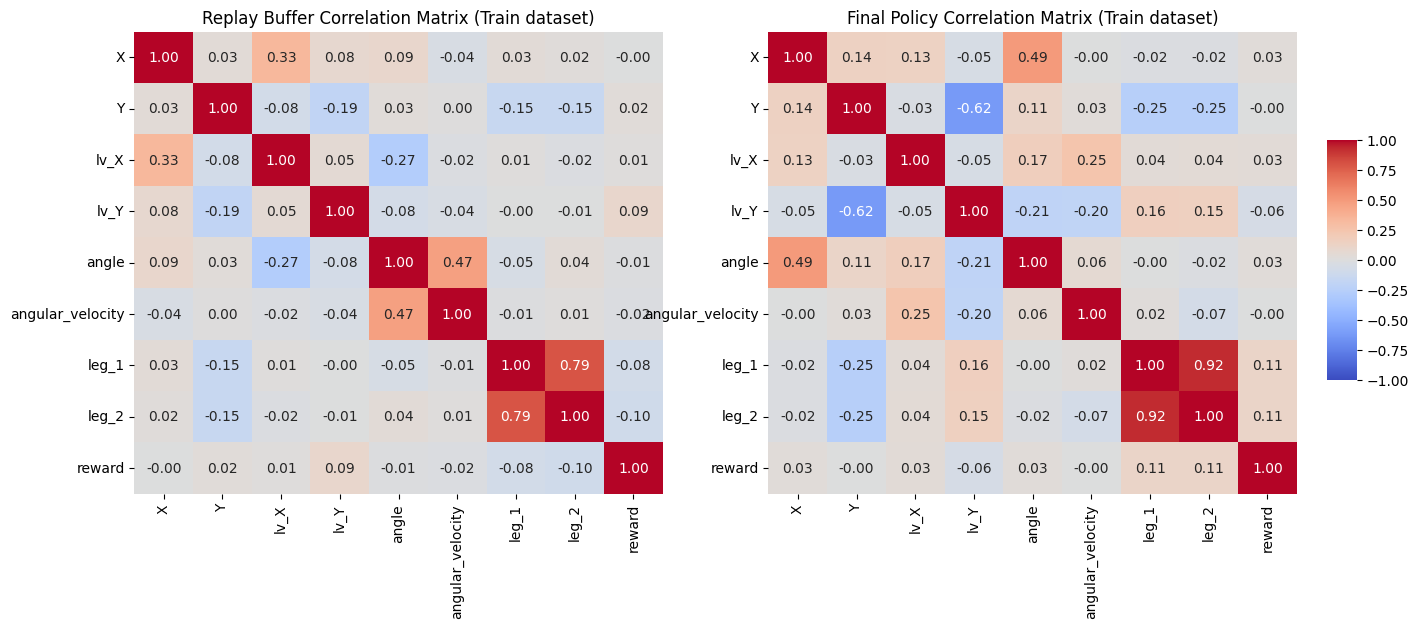

In [11]:
rb_corr_matrix = rb_train_df.drop(columns=['action', 'done', 'episode']).corr()
fp_corr_matrix = fp_train_df.drop(columns=['action', 'done', 'episode']).corr()

corr_matrices_fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
cbar_ax = corr_matrices_fig.add_axes([0.92, 0.3, 0.02, 0.4])

sns.heatmap(
    rb_corr_matrix,
    vmin=-1,
    vmax=1,
    ax=axes[0],
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    cbar=False
)
axes[0].set_title('Replay Buffer Correlation Matrix (Train dataset)')

sns.heatmap(
    fp_corr_matrix,
    vmin=-1,
    vmax=1,
    ax=axes[1],
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    cbar_ax=cbar_ax
)
axes[1].set_title('Final Policy Correlation Matrix (Train dataset)')

plots_dict['../plots/corr_matrices_fig.png']=corr_matrices_fig
plt.show(corr_matrices_fig)

In [12]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

from src.utils.plotting import plot_feature_importance_heatmaps


def prepare_data(df: pd.DataFrame, drop_cols: List[str]) -> Tuple[torch.Tensor, torch.Tensor]:
    X = df.drop(columns=drop_cols).to_numpy(dtype=np.float32)
    Y = df['action'].to_numpy(dtype=np.uint8)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.uint8)

cols_to_drop = ['done', 'episode', 'action']
rb_X_train, rb_Y_train = prepare_data(rb_train_df, cols_to_drop)
fp_X_train, fp_Y_train = prepare_data(fp_train_df, cols_to_drop)

feature_names = fp_train_df.drop(columns=cols_to_drop).columns.tolist()

def get_feature_importance_df(X: np.array,
                              y: np.array,
                              feature_names: str,
                              log_reg_config: dict) -> pd.DataFrame:
    action_names = ['do nothing', 'fire left orientation engine', 'fire main engine', 'fire right orientation engine']
    model = LogisticRegression(class_weight='balanced', **log_reg_config)
    model.fit(X, y)

    feature_importance = pd.DataFrame(np.abs(model.coef_).T, columns=action_names)
    feature_importance['feature'] = feature_names
    feature_importance['Avg. feature importance'] = feature_importance.drop(columns=['feature']).mean(axis=1)
    return feature_importance


def process_dataset_for_feature_importance(dataset_name: str,
                                           X_train: torch.Tensor,
                                           Y_train: torch.Tensor) -> plt.figure:
    normalization_techniques = {
        'raw': None,
        'Max Abs': torch.jit.load(f'../models/{dataset_name}/normalization/max_abs_normalization.pt'),
        'Min Max': torch.jit.load(f'../models/{dataset_name}/normalization/min_max_normalization.pt'),
        'Robust': torch.jit.load(f'../models/{dataset_name}/normalization/robust_normalization.pt'),
        'Standard (z-score)': torch.jit.load(f'../models/{dataset_name}/normalization/standard_normalization.pt'),
    }

    dataset_config =load_yaml_config('../config/log_reg_feature_importance_config.yaml')
    f_imp_stats = {}
    for norm_name, norm_script in tqdm(normalization_techniques.items(), desc='Normalization techniques'):
        if norm_script is not None:
            X, y = norm_script(X_train), Y_train
        else:
            X, y = X_train, Y_train

        f_imp_stats[norm_name] = get_feature_importance_df(
            X=X,
            y=y,
            feature_names=feature_names,
            log_reg_config=dataset_config
        )
    return plot_feature_importance_heatmaps(f_imp_stats)

## Feature Importance

Normalization techniques: 100%|██████████| 5/5 [01:16<00:00, 15.39s/it]


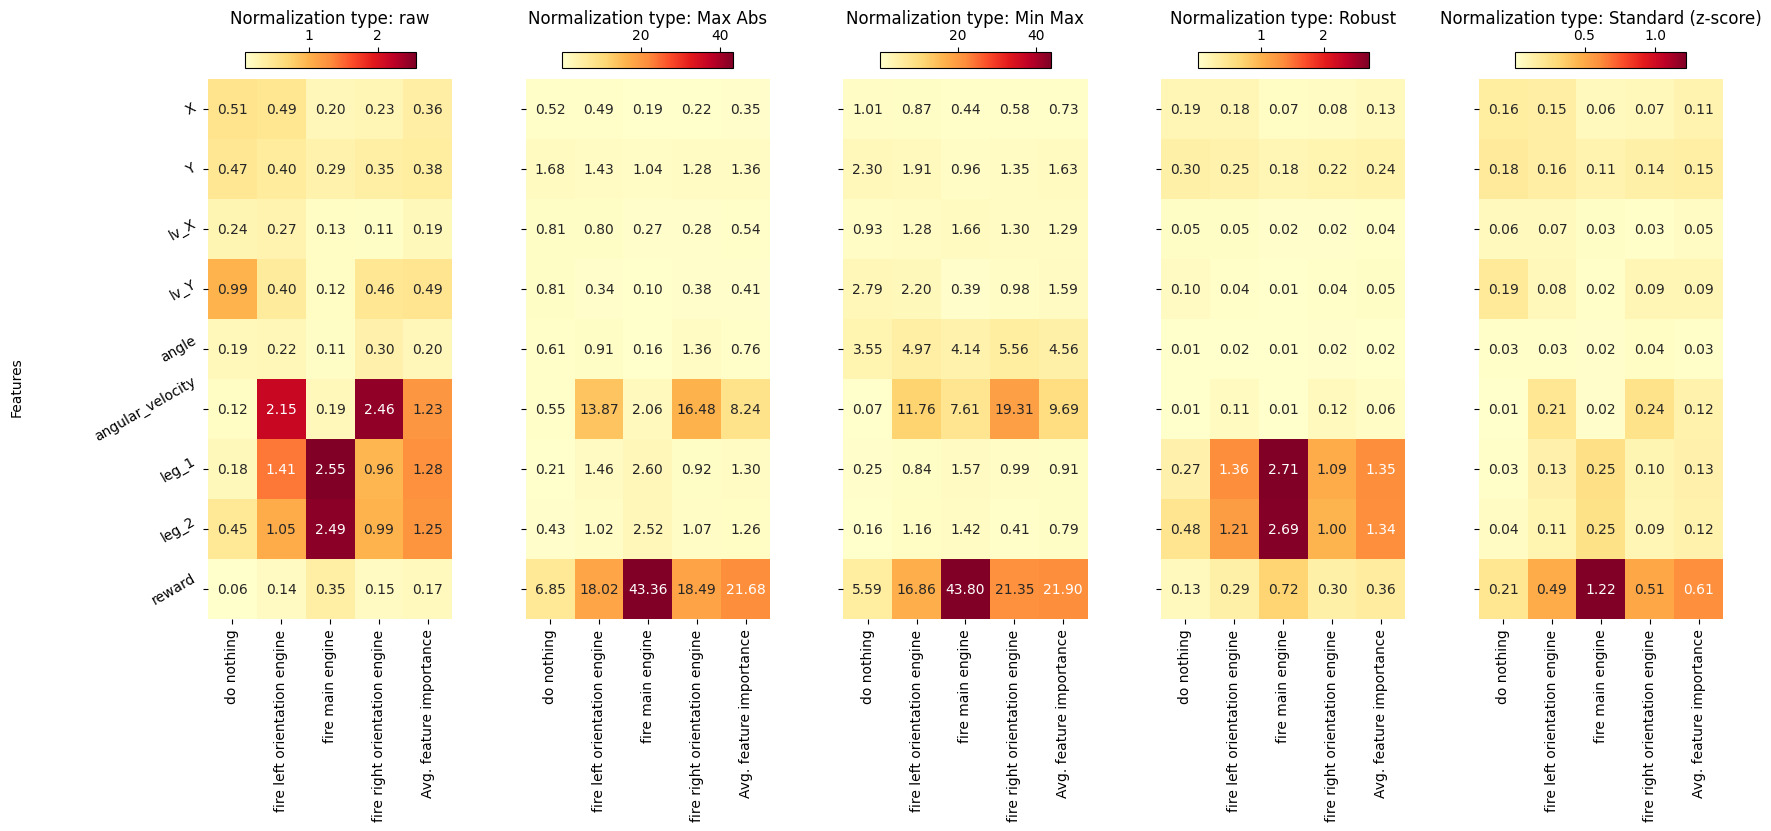

In [13]:
rb_feature_importance_fig = process_dataset_for_feature_importance(dataset_name= 'replay_buffer',
                                       X_train=rb_X_train,
                                       Y_train=rb_Y_train)

plots_dict['../plots/rb_feature_importance_fig.png']=rb_feature_importance_fig
plt.show(rb_feature_importance_fig)

Normalization techniques: 100%|██████████| 5/5 [01:23<00:00, 16.73s/it]


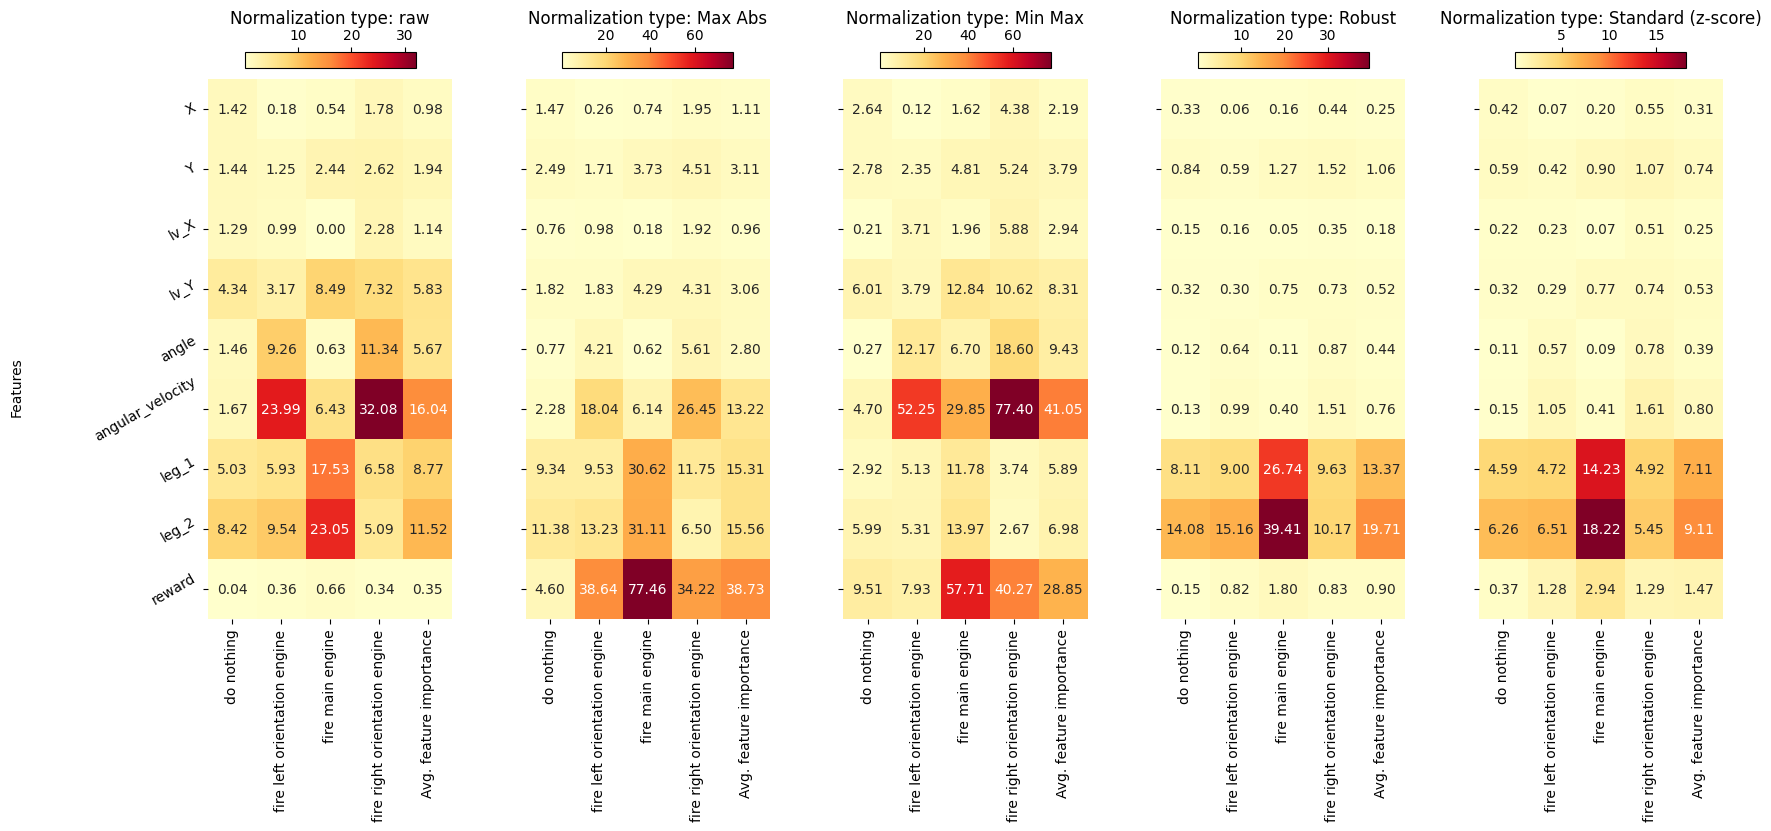

In [14]:
fp_feature_importance_fig = process_dataset_for_feature_importance(dataset_name= 'final_policy',
                                       X_train=fp_X_train,
                                       Y_train=fp_Y_train)

plots_dict['../plots/fp_feature_importance_fig.png']=fp_feature_importance_fig
plt.show(fp_feature_importance_fig)

## Save the plots as files

In [15]:
for fig_path, fig in tqdm(plots_dict.items(), desc='Saving plots as files'):
    fig.savefig(fig_path)

Saving plots as files: 100%|██████████| 9/9 [00:04<00:00,  1.94it/s]
